In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.font_manager as fm
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

### Binary Classification 실습 :
### NBA 신인 선수들의 경기 수치를 통한 커리어 5년 지속 가능성 예측

    - GP : 경기 수  MIN : 출전 시간(분)  PTS : 경기 당 점수  FGM : 필드골 평균 성공 횟수
    - FGA : 필드골 평균 시도 횟수  FG% : 필드골 성공률  3P MADE : 3점슛 평균 성공 횟수
    - 3PA : 3점슛 평균 시도 횟수  3P% : 3점슛 성공률  FTM : 자유투 평균 성공 횟수
    - FTA : 자유투 평균 시도 횟수  FT% : 자유투 성공률  OREB : 공격시 평균 리바운드 횟수
    - DREB : 수비시 평균 리바운드 횟수  REB : 총 리바운드  AST : 어시스트 평균 횟수
    - STL : 스틸 평균 횟수  BLK : 블락 평균 횟수  TOV : 턴오버 평균 횟수
    - TARGET_5Yrs < 5 -> 0 / TARGET_5Yrs >= 5 -> 1

In [14]:
df = pd.read_csv('data/merged_NBA_players.csv', index_col = 'Unnamed: 0')
df

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,TOV,TARGET_5Yrs,height_x,weight_x,born,birth_city,birth_state,position,birth_date,college
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,1.3,0.0,206.0,86.0,1997.0,Kinston,North Carolina,F,1997-09-02,Duke University
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,1.6,0.0,198.0,96.0,1994.0,San Antonio,Texas,G,1994-10-28,University of Kentucky
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.0,0.0,211.0,106.0,1983.0,Inglewood,California,G-F,1993-03-20,St. John's University
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.0,1.0,203.0,86.0,1970.0,Bronx,New York,G,1970-02-01,St. John's University
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,0.8,1.0,213.0,110.0,1969.0,Salem,Massachusetts,C,1969-09-10,Georgia Institute of Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,Byron Houston,79,16.1,5.3,1.8,4.1,44.6,0.0,0.1,28.6,...,1.1,0.0,196.0,113.0,1969.0,Watonga,Kansas,F,1969-11-22,Oklahoma State University
1228,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.3,1.0,185.0,74.0,1968.0,Shawnee,Oklahoma,G,1968-12-09,University of Oklahoma
1229,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,0.9,0.0,203.0,113.0,1969.0,Chicago,Illinois,F,1969-02-19,University of Texas at El Paso
1230,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,0.8,1.0,185.0,83.0,1970.0,Pascagoula,Mississippi,G,1970-03-07,University of Georgia


In [58]:
df.rename( columns = {'FG%':'FGP', '3P%':'3PP', 'FT%':'FTP', '3P Made':'3PM'}, inplace=True )

In [59]:
df.isnull().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FGP             0
3PM             0
3PA             0
3PP             8
FTM             0
FTA             0
FTP             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
height_x        0
weight_x        0
born            0
birth_city     37
birth_state    39
position        0
birth_date      0
college        22
dtype: int64

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1231
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1232 non-null   object 
 1   GP           1232 non-null   int64  
 2   MIN          1232 non-null   float64
 3   PTS          1232 non-null   float64
 4   FGM          1232 non-null   float64
 5   FGA          1232 non-null   float64
 6   FGP          1232 non-null   float64
 7   3PM          1232 non-null   float64
 8   3PA          1232 non-null   float64
 9   3PP          1224 non-null   float64
 10  FTM          1232 non-null   float64
 11  FTA          1232 non-null   float64
 12  FTP          1232 non-null   float64
 13  OREB         1232 non-null   float64
 14  DREB         1232 non-null   float64
 15  REB          1232 non-null   float64
 16  AST          1232 non-null   float64
 17  STL          1232 non-null   float64
 18  BLK          1232 non-null   float64
 19  TOV   

In [61]:
df.columns

Index(['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FGP', '3PM', '3PA', '3PP',
       'FTM', 'FTA', 'FTP', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs', 'height_x', 'weight_x', 'born', 'birth_city',
       'birth_state', 'position', 'birth_date', 'college'],
      dtype='object')

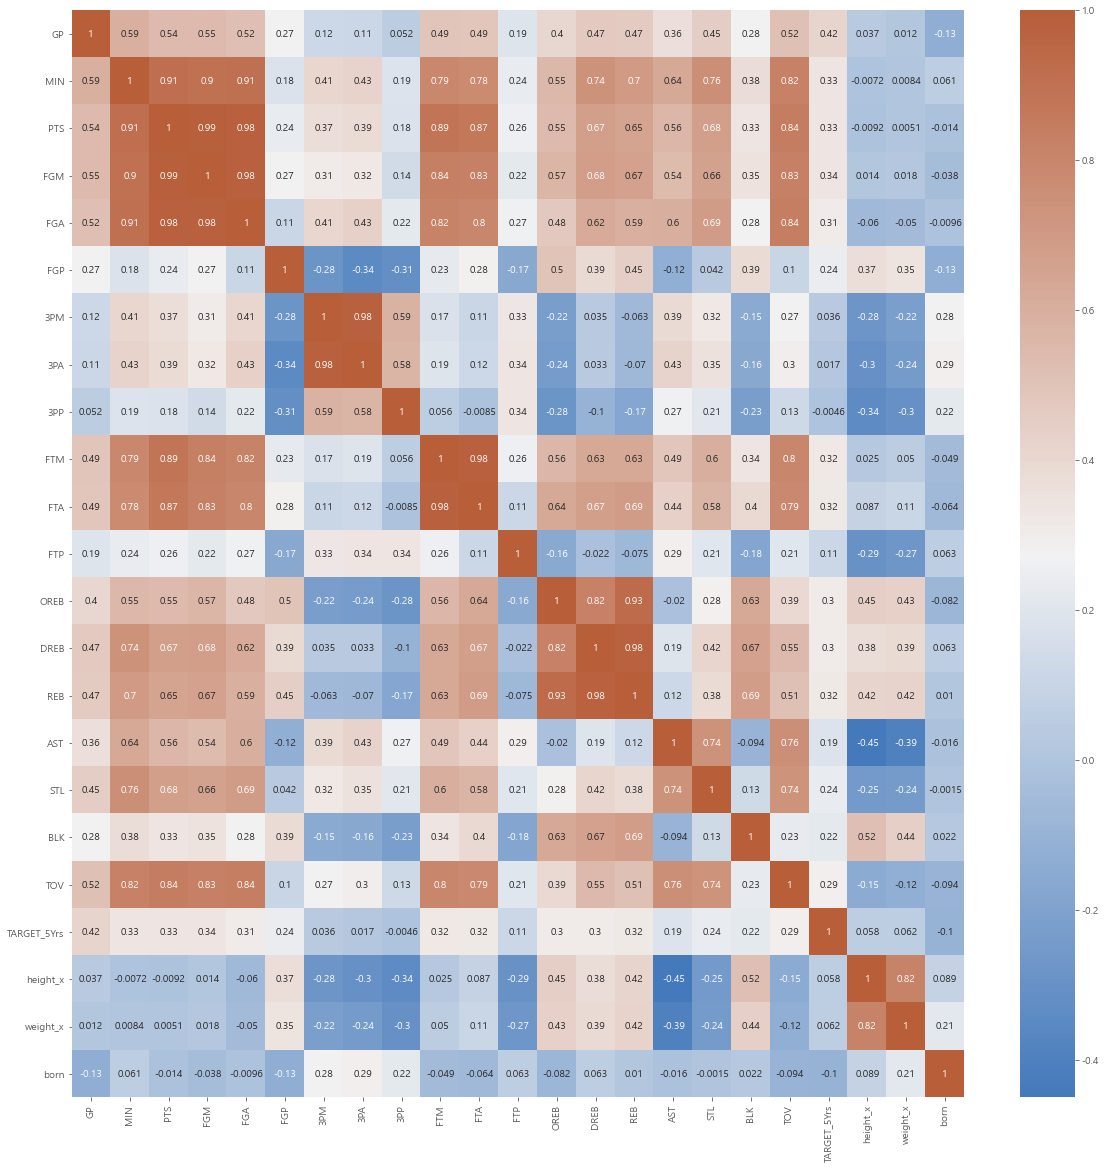

In [63]:
#변수 간 다중공선성 heatmap으로 확인
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(df.corr(), annot=True, cmap=cmap)
plt.show()

#### VIF(Variance Inflation Factor)를 사용하여 의존적인 변수 삭제

In [56]:
df.shape[1]

29

In [74]:
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices("TARGET_5Yrs ~ MIN" , df, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[['GP', 'MIN', 'PTS', 'FGM', '3PM', 'FGA', 'FGP', '3PA',
       'FTM', 'FTA', 'FTP', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV']].values, i) for i in range(17)]
vif['features'] = ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FGP', '3PA', '3PM'
        'FTM', 'FTA', 'FTP', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV']
vif

,VIF Factor,features
0,22.015030,GP
1,87.720535,MIN
2,11388.352363,PTS
3,6829.361954,FGM
4,83.772053,FGA
5,297.777222,FGP
6,72.069703,3PA
7,64.634754,3PMFTM
8,592.179857,FTA
9,174.040933,FTP


In [75]:
vif.sort_values(by = 'VIF Factor',ascending = False)

,VIF Factor,features
2,11388.352363,PTS
3,6829.361954,FGM
13,5057.046886,AST
12,2256.473618,REB
11,625.584075,DREB
8,592.179857,FTA
5,297.777222,FGP
9,174.040933,FTP
1,87.720535,MIN
4,83.772053,FGA
